# Imports
## Pip Packages

In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from tqdm import tqdm
from random import randint
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)

from src.datasets import FreeViewInMemory, seq2seq_jagged_collate_fn, seq2seq_padded_collate_fn
from src.model import PathModel
from src.cls_metrics import precision,recall,create_cls_targets, accuracy
from src.eval_utils import plt_training_metrics
from src.vis_scanpath import draw_scanpath_mpl
from src.model_io import load_model_for_eval


# Training

## Preparing Data

In [2]:
# TODO Separate validation and test sets
datasetv2 = FreeViewInMemory(sample_size= 13,log = True, start_index=2)
total_size = len(datasetv2)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_set, val_set, test_set = random_split(datasetv2, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0, collate_fn= seq2seq_padded_collate_fn)
val_dataloader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=0, collate_fn= seq2seq_padded_collate_fn)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=0, collate_fn= seq2seq_padded_collate_fn)

Data loaded in memory


# Eval

## Review Metrics

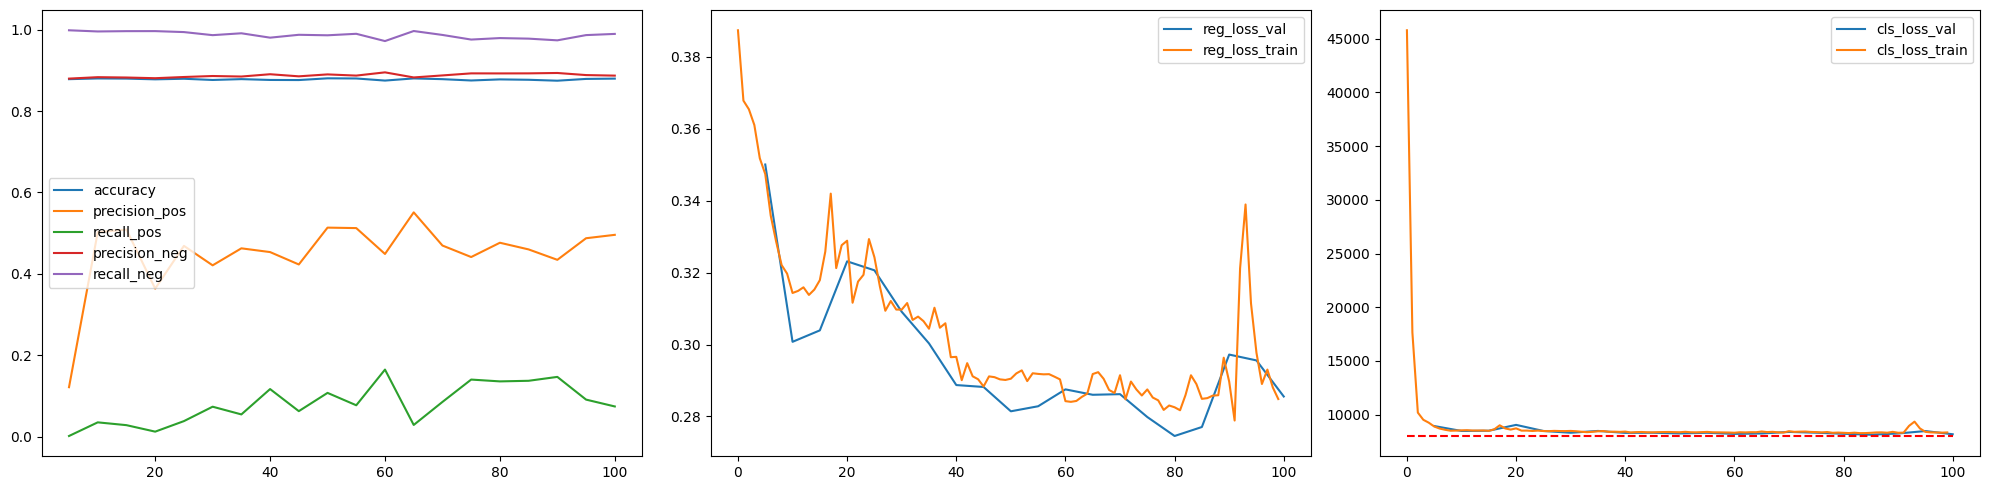

In [3]:

plt_training_metrics("C:\\Users\\ulloa\\OneDrive\\Desktop\\Practicas\\projectes\\Dataset\\Output\\metrics\\metrics 100.json")

## Checkout Output

### Load Model

In [4]:

model = load_model_for_eval('outputs\\2025-11-17\\14-23-24\\')


CUDA not available, using CPU.


### Load Batch of data

In [ ]:
device = 'cpu'

for batch in tqdm(test_dataloader):
        x,x_mask,y, y_mask, fixation_len = batch
        x = x.to(device=device)
        y = y.to(device=device)
        if x_mask is not None:
            x_mask = x_mask.to(device = device)
        if y_mask is not None:
            y_mask = y_mask.to(device = device)
        fixation_len = fixation_len.to(device = device)
        break

  0%|          | 0/28 [00:03<?, ?it/s]


### Eval

In [10]:
with torch.no_grad():
    reg_out,cls_out = model(x,y, x_mask, y_mask)
    cls_targets = create_cls_targets(cls_out, fixation_len)
    print('accuracy: ',accuracy(cls_out, y_mask, cls_targets))
    print('precision_pos: ',precision(cls_out, y_mask, cls_targets))
    print('recall_pos: ',recall(cls_out, y_mask, cls_targets))
    print('precision_neg: ',precision(cls_out, y_mask, cls_targets, cls = 0))
    print('recall_neg: ',recall(cls_out, y_mask, cls_targets, cls = 0))

accuracy:  0.8688995215311005
precision_pos:  0.2857142857142857
recall_pos:  0.046875
precision_neg:  0.880859375
recall_neg:  0.9836423118865867


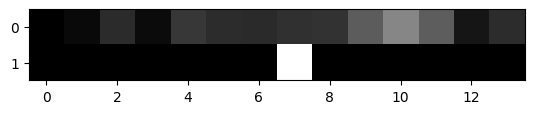

In [59]:
idx = randint(0,128-1)
cls_out_sample = cls_out[idx]
cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
cls_targets_sample = cls_targets[idx].cpu().numpy().T
# vstack
pair = np.vstack((cls_out_sample, cls_targets_sample)).T
plt.imshow(pair.T, cmap='gray')
plt.show()

In [60]:
cls_out_sample.shape

(1, 14)

skipping sample  3
skipping sample  28
skipping sample  49
skipping sample  59
skipping sample  77
skipping sample  118
(7,)


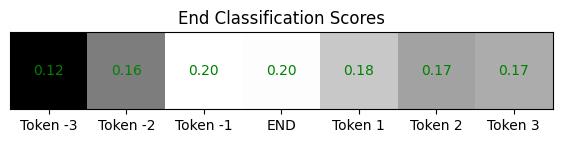

In [85]:
acum = np.zeros(7)
count = 0
for i in range(cls_out.shape[0]):
    cls_out_sample = cls_out[i]
    cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
    if fixation_len[i] < 3 or fixation_len[i] > cls_out_sample.shape[1]-4:
        print('skipping sample ', i)
        continue
    acum += cls_out_sample[0,fixation_len[i]-3: fixation_len[i]+4 ]
    count +=1
avg = acum / count
print(acum.shape)
avg = avg.reshape(7,1)
# put the value in each pixel
def plot_classification_scores(scores_array, title="Classification Scores"):
    image_data = scores_array.reshape(7, 1).T
    plt.figure(figsize=(7,1)) # Set the figure size to be tall and thin
    plt.imshow(image_data, cmap='gray', interpolation='nearest', aspect='auto')
    text_color = 'green' 
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            score = image_data[i, j]
            
            plt.text(j, i, f'{score:.2f}', 
                     ha="center", va="center", color=text_color, fontsize=10)

    plt.title(title)
    plt.xticks(range(7), [f'Token {i-3}' if i != 3 else 'END' for i in range(7)]) # Optional: keep y-axis labels for reference
    plt.yticks([])
    plt.show()
plot_classification_scores(avg, title="End Classification Scores")

In [5]:
def get_coords(idx, x,y, fixation_len, reg_out):
    x_coords = x[idx,:,:2].cpu().numpy().T
    y_coords = y[idx,:fixation_len[idx],:2].cpu().numpy().T
    reg_coords = reg_out[idx,:fixation_len[idx],:2].cpu().numpy().T
    x_coords = x_coords[:,::-1]
    y_coords = y_coords[:,::-1]
    reg_coords = reg_coords[:,::-1]
    return x_coords, y_coords, reg_coords

def batch_to_list(x, fixation_len = None):
    # convert from padded batch [B,T,F] to list of numpy arrays with shape [F,N]
    x_list = []
    for i in range(x.size(0)):
        l = 0
        if fixation_len is None:
            l = x.size(1)
        else:
            l = fixation_len[i]
        x_i = x[i,:l, :].cpu().numpy().T
        x_list.append(x_i)
    return x_list


tensor(8)


c:\Users\ulloa\OneDrive\Desktop\Practicas\projectes\Dataset\src\vis_scanpath.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[0], y[0], s=marker_size, c=end_color, zorder=5)


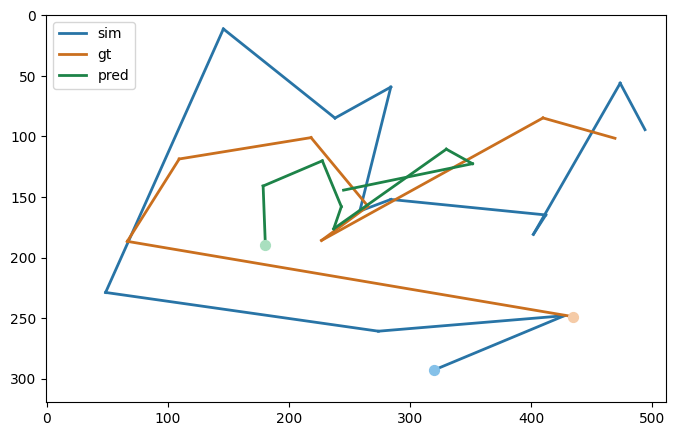

tensor(7)


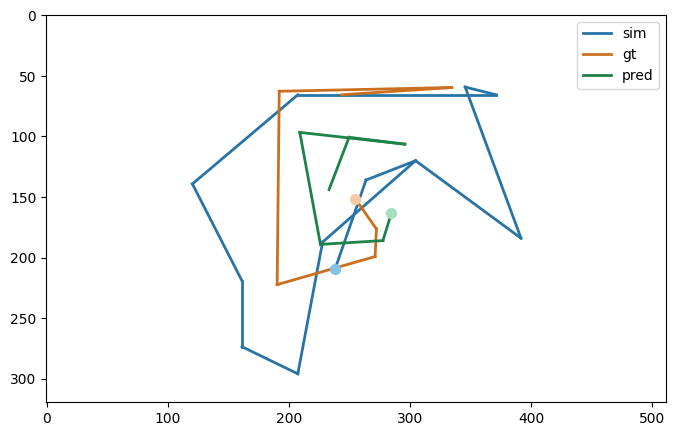

tensor(6)


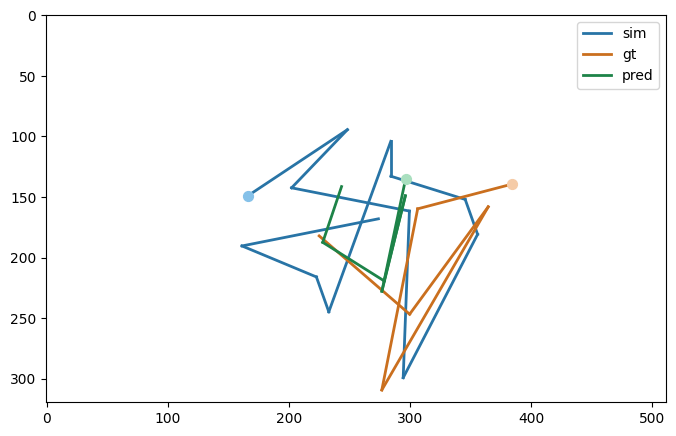

tensor(8)


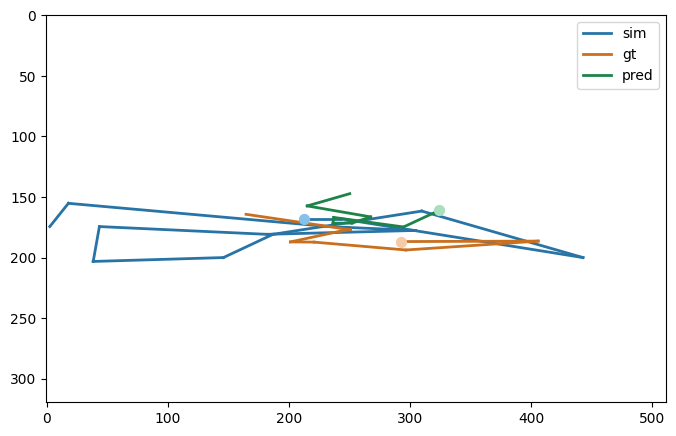

tensor(6)


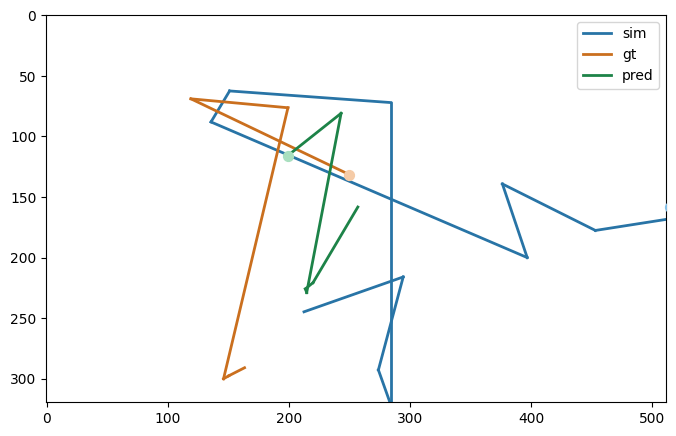

In [73]:
for i in range(5):

    idx = randint(0,128-1)
    x_coords, y_coords, reg_coords = get_coords(idx, x, y, fixation_len,reg_out)
    img = np.ones((320,512,3),dtype=np.uint8)*255

    label = ['sim', 'gt', 'pred']

    traj = [x_coords,
            y_coords, 
            reg_coords]
    traj_colors = [(40/255, 116/255, 166/255), # blue
                (202/255, 111/255, 30/255), # orange
                (29/255, 131/255, 72/255)] # green

    end_point_colors = [(133/255, 193/255, 233/255),
                        (245/255, 203/255, 167/255),
                        (169/255, 223/255, 191/255)]
    fig, ax = plt.subplots(figsize=(8,8))
    for traj, color, end_color, lbl in zip(traj, traj_colors, end_point_colors, label):
        ax = draw_scanpath_mpl(ax, traj[0],traj[1], color=color, end_color=end_color, label=lbl)

    print(fixation_len[idx])

    plt.imshow(img)
    plt.legend()
    plt.savefig(f'Output/scanpath_{i}.png')
    plt.show()


### Eval Stats

In [ ]:
with torch.no_grad():
    acc_acum = 0
    pre_pos_acum = 0
    rec_pos_acum = 0
    pre_neg_acum = 0
    rec_neg_acum = 0
    count = 0
    reg_results = []
    y_results = []
    x_results = []
    for batch in tqdm(test_dataloader):
            x,x_mask,y, y_mask, fixation_len = batch
            x = x.to(device=device)
            y = y.to(device=device)
            if x_mask is not None:
                x_mask = x_mask.to(device = device)
            if y_mask is not None:
                y_mask = y_mask.to(device = device)
            fixation_len = fixation_len.to(device = device)
            reg_out,cls_out = model(x,y, x_mask, y_mask)
            reg_results += batch_to_list(reg_out, fixation_len)
            y_results += batch_to_list(y, fixation_len)
            x_results += batch_to_list(x)
            cls_targets = create_cls_targets(cls_out, fixation_len)
            acc_acum += accuracy(cls_out, y_mask, cls_targets)
            pre_pos_acum += precision(cls_out, y_mask, cls_targets)
            rec_pos_acum += recall(cls_out, y_mask, cls_targets)
            pre_neg_acum += precision(cls_out, y_mask, cls_targets, cls = 0)
            rec_neg_acum += recall(cls_out, y_mask, cls_targets, cls = 0)
            count += 1
    
acc = acc_acum/count
pre_pos = pre_pos_acum/count
rec_pos = rec_pos_acum/count
pre_neg = pre_neg_acum/count
rec_neg = rec_neg_acum/count
print(acc)
print(pre_pos)
print(rec_pos)
print(pre_neg)
print(rec_neg)
x_list = [x_results,'sim', 1/16]
y_list = [y_results,'fixations', 1/16]
reg_list = [reg_results,'pred', 1/16]

gaze_list = [x_list, y_list, reg_list]

100%|██████████| 28/28 [00:41<00:00,  1.48s/it]


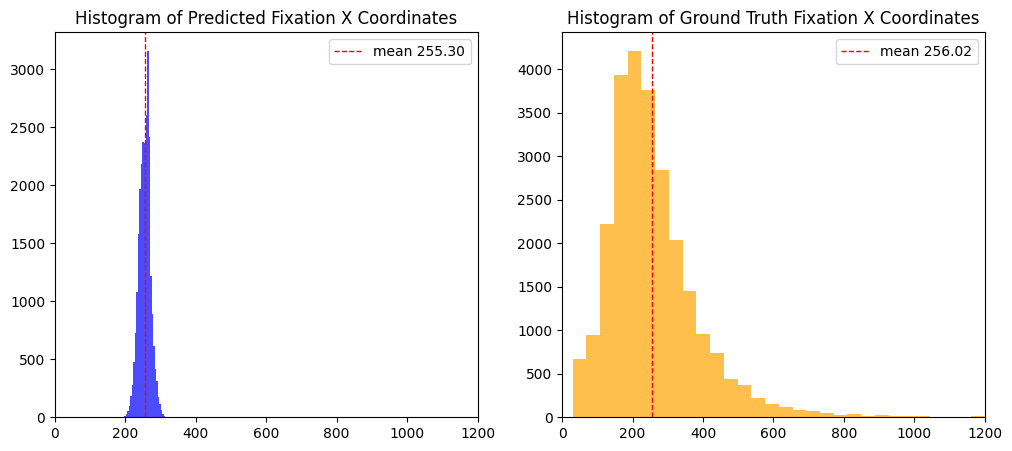

In [36]:
concatenated_reg = np.concat([reg[2] for reg in reg_results])
concatenated_y = np.concat([y[2] for y in y_results])

# plot a hist of each array in two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(concatenated_reg, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Predicted Fixation X Coordinates')
axs[0].set_xlim(0, 1200)
axs[0].axvline(np.mean(concatenated_reg), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_reg):.2f}')
axs[0].legend()
axs[1].hist(concatenated_y, bins=30, color='orange', alpha=0.7)
axs[1].set_title('Histogram of Ground Truth Fixation X Coordinates')
axs[1].set_xlim(0, 1200)
axs[1].axvline(np.mean(concatenated_y), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_y):.2f}')
axs[1].legend()
plt.show()

    


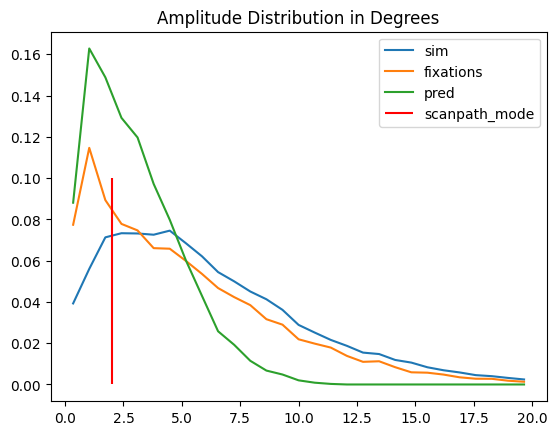

In [63]:
from src.eval_utils import plot_amplitude_dist, plot_angle_distribution, plot_autocorrelation, plot_consecutive_angles, plot_vector_dist, calculate_relative_vectors                        
plot_amplitude_dist([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list],
                    [gaze[2] for gaze in gaze_list])

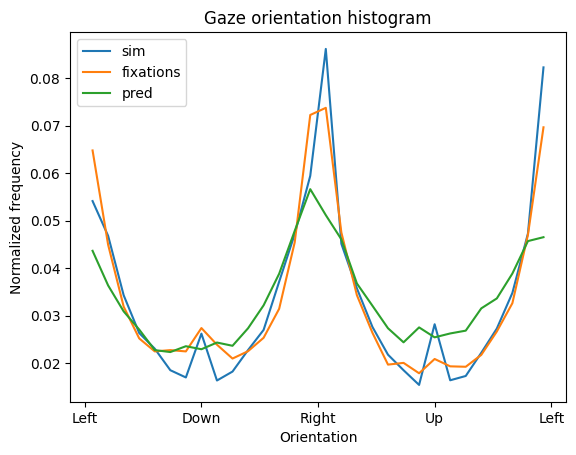

In [64]:
plot_angle_distribution([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

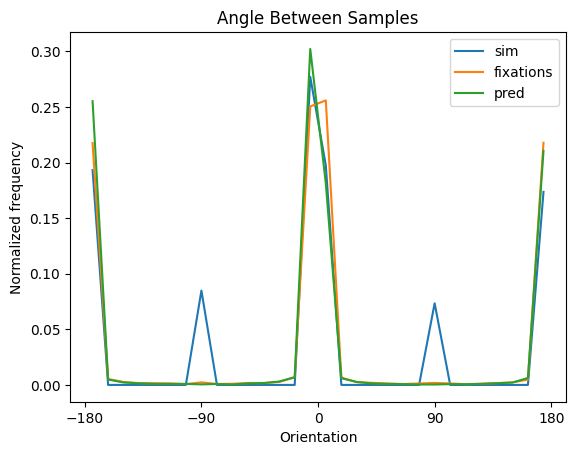

In [65]:
plot_consecutive_angles([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

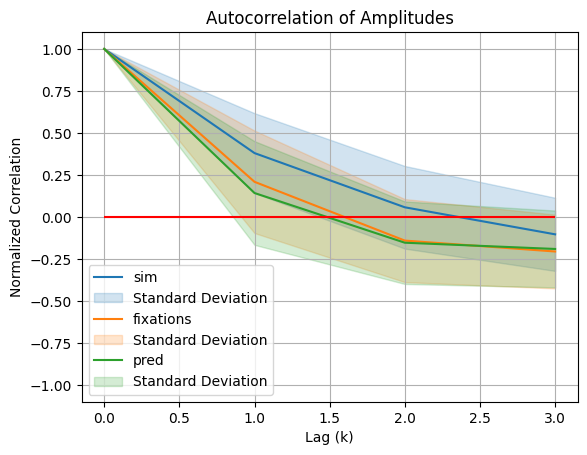

In [66]:
plot_autocorrelation([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list], min_len=4)
plt.show()

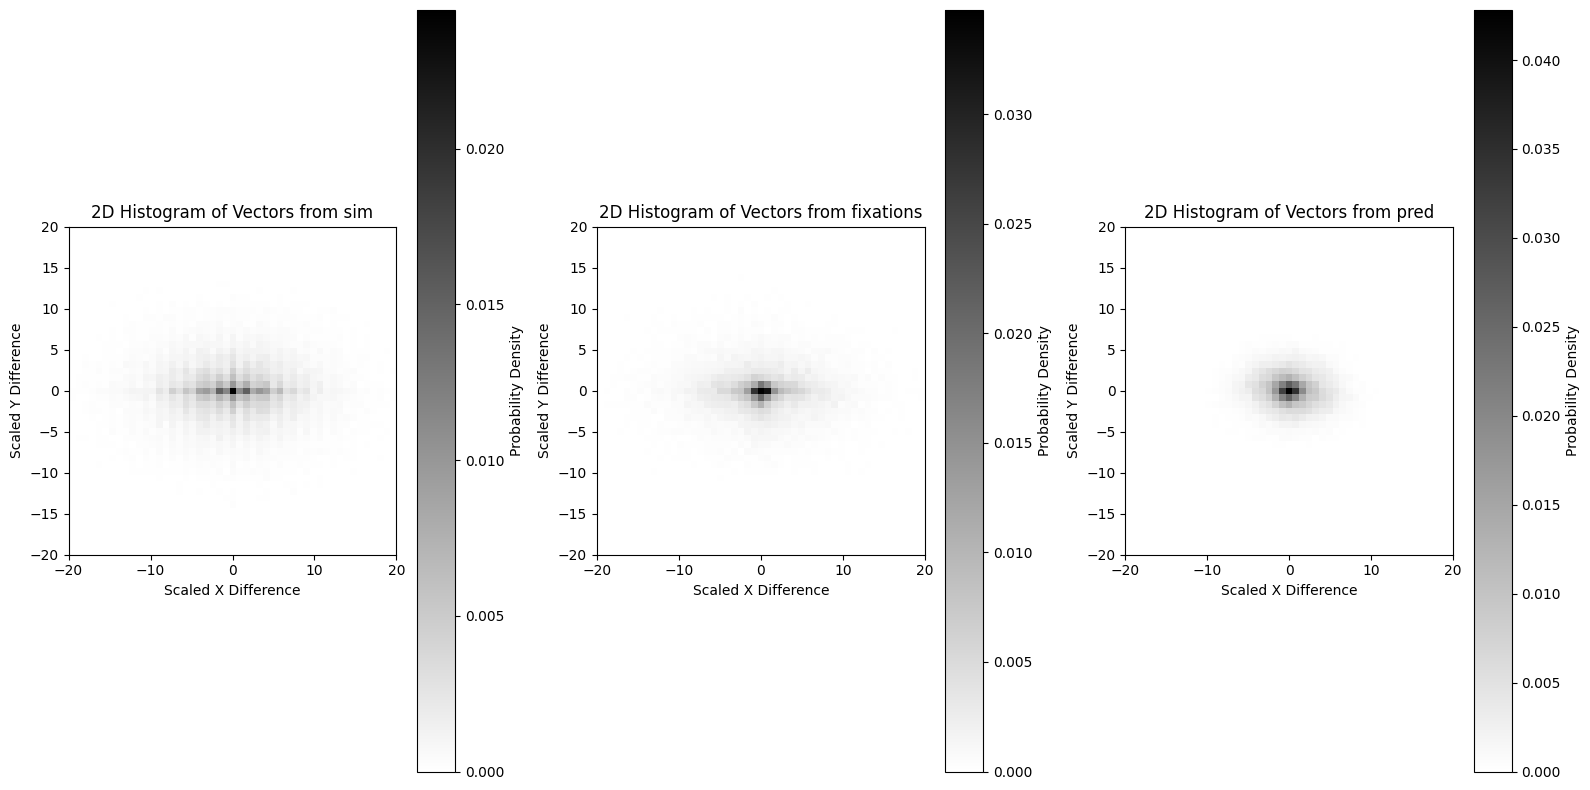

In [67]:
plot_vector_dist([[np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in gaze[0]] for gaze in gaze_list],
                 [gaze[2] for gaze in gaze_list], 
                 [gaze[1] for gaze in gaze_list],)

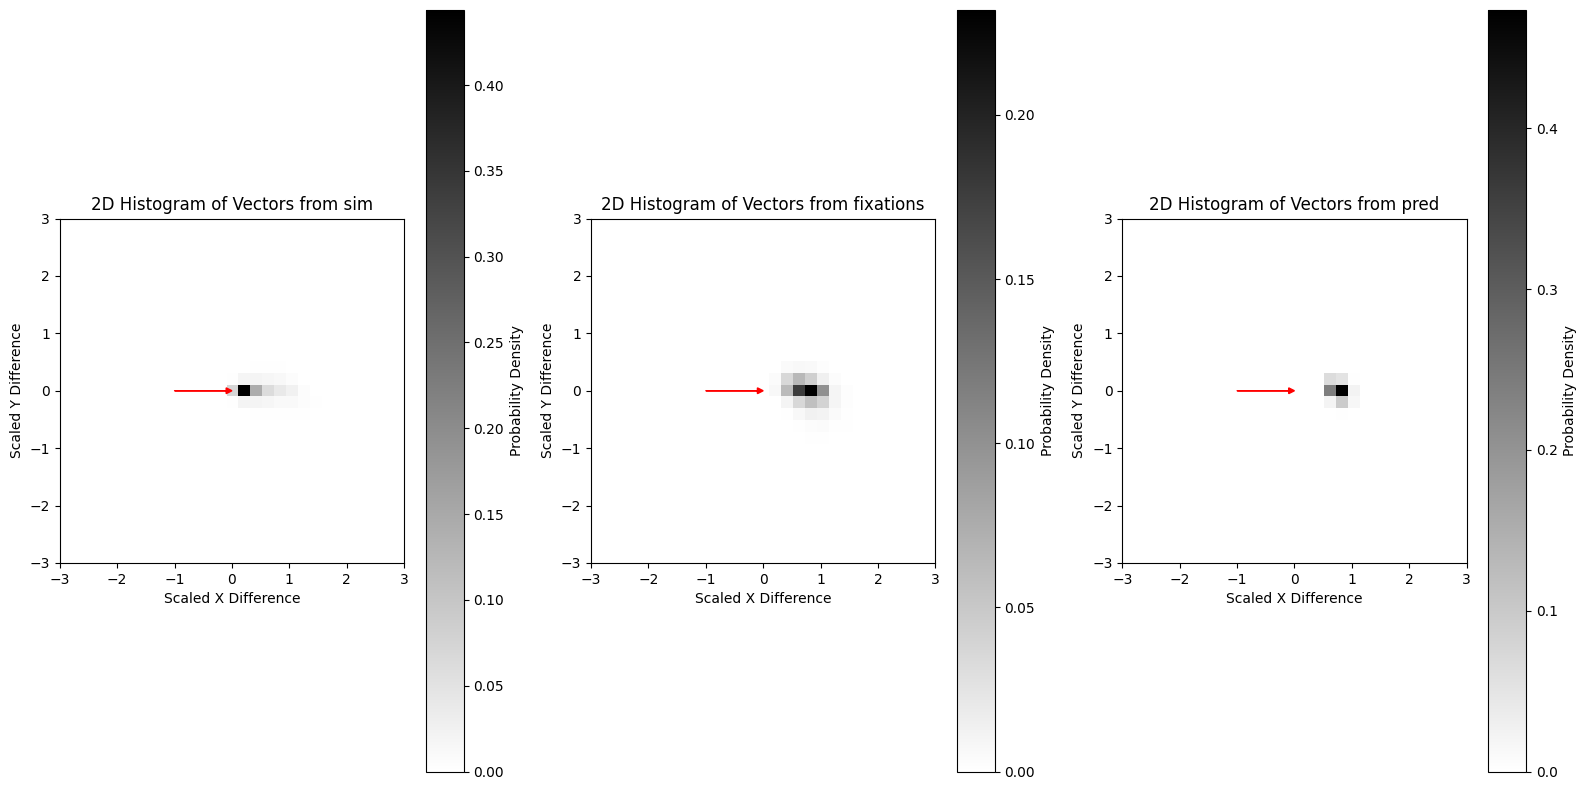

In [68]:
plot_vector_dist([[calculate_relative_vectors(gaze_sample) for gaze_sample in gaze[0]] for gaze in gaze_list],
                    [1 for _ in gaze_list],
                    [gaze[1] for gaze in gaze_list],-3,3,30, arrow= True)

plt.show()